In [1]:
import pandas as pd
import numpy as np

# 可視化用のライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import neologdn
import MeCab

import re

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
# # プログレスバーのラベル設定
tqdm_notebook.pandas(desc="progress: ")

In [2]:
# 予めtf値とidf値を紐付けていたcsvファイルを読み込む
idf_merge_df = pd.read_csv('idf_merge_df.csv', encoding='shift_jis')
idf_merge_df.head()

,内容,original_type,count,word_count,tf,word_include_text_count,all_text_count,idf
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,(_記号-一般,1,26,0.038462,1,4,2.386294
1,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,)_記号-一般,1,26,0.038462,1,4,2.386294
2,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,._記号-一般,1,26,0.038462,1,4,2.386294
3,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,1_名詞-数,1,26,0.038462,1,4,2.386294
4,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,NEologd_名詞-固有名詞-一般,1,26,0.038462,1,4,2.386294


## TFIDF値を算出し新規カラムを作成

In [3]:
idf_merge_df['tf_idf'] = idf_merge_df['tf'] * idf_merge_df['idf']
idf_merge_df.head()

,内容,original_type,count,word_count,tf,word_include_text_count,all_text_count,idf,tf_idf
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,(_記号-一般,1,26,0.038462,1,4,2.386294,0.091781
1,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,)_記号-一般,1,26,0.038462,1,4,2.386294,0.091781
2,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,._記号-一般,1,26,0.038462,1,4,2.386294,0.091781
3,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,1_名詞-数,1,26,0.038462,1,4,2.386294,0.091781
4,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,NEologd_名詞-固有名詞-一般,1,26,0.038462,1,4,2.386294,0.091781


In [4]:
# 複数の文書に出現する単語（ここではParse_名詞-固有名詞-一般)を抽出し、各tf_idfの値を確認
idf_merge_df.query("original_type == 'Parse_名詞-固有名詞-一般' ")

,内容,original_type,count,word_count,tf,word_include_text_count,all_text_count,idf,tf_idf
5,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,Parse_名詞-固有名詞-一般,1,26,0.038462,2,4,1.693147,0.065121
6,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「＼n」で区切り、...,Parse_名詞-固有名詞-一般,1,30,0.033333,2,4,1.693147,0.056438


## 単語毎の標準偏差を算出

In [5]:
std_df = idf_merge_df[['original_type', 'tf_idf']]
std_df = std_df.groupby('original_type').std(ddof=0)#標準偏差をn法で計算するには ddof=0
std_df = std_df.reset_index().rename(columns={'tf_idf':'std_tf_idf'})
std_df = std_df.sort_values(by='std_tf_idf', ascending=False)# 標準偏差が大きい＝特徴がある単語
std_df

,original_type,std_tf_idf
32,で_助詞-格助詞-一般,0.029276
67,＼_記号-一般,0.023088
20,「_記号-括弧開,0.023088
22,」_記号-括弧閉,0.019835
26,する_動詞-自立,0.019791
44,れる_動詞-接尾,0.018747
25,が_助詞-格助詞-一般,0.018747
14,t_名詞-固有名詞-組織,0.015643
51,単語_名詞-一般,0.015239
55,型_名詞-接尾-一般,0.015142


## 標準偏差の頻度をヒストグラムで描画

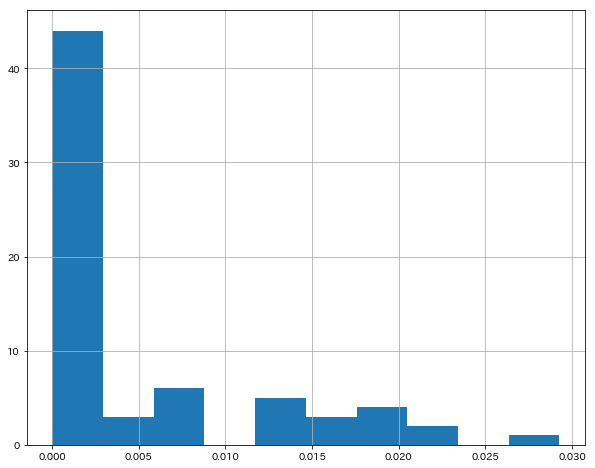

In [6]:
# 標準偏差の値をヒストグラムで描画
std_df['std_tf_idf'].hist(figsize=(10,8))

# グラフより、標準偏差が0.010未満の単語はどの文書にも出現しており特徴がない単語と言える
# 以降、標準偏差が0.010以上の単語のみを特徴量として選択

In [7]:
# 採用する特徴量一覧
adopt_feature_word_df = std_df[ std_df['std_tf_idf'] >= 0.010 ]
adopt_feature_word_df

,original_type,std_tf_idf
32,で_助詞-格助詞-一般,0.029276
67,＼_記号-一般,0.023088
20,「_記号-括弧開,0.023088
22,」_記号-括弧閉,0.019835
26,する_動詞-自立,0.019791
44,れる_動詞-接尾,0.018747
25,が_助詞-格助詞-一般,0.018747
14,t_名詞-固有名詞-組織,0.015643
51,単語_名詞-一般,0.015239
55,型_名詞-接尾-一般,0.015142


In [8]:
# 採用しない特徴量一覧
drop_feature_word_df = std_df[ std_df['std_tf_idf'] < 0.010 ]
drop_feature_word_df

,original_type,std_tf_idf
57,文字列_名詞-固有名詞-一般,0.007571
46,リスト_名詞-一般,0.007571
54,品詞_名詞-一般,0.006907
36,など_助詞-副助詞,0.006907
52,原形_名詞-一般,0.006907
62,表示_名詞-サ変接続,0.006907
38,に_助詞-格助詞-一般,0.005131
9,Parse_名詞-固有名詞-一般,0.004341
31,て_助詞-接続助詞,0.004341
27,た_助動詞,0.002565


In [9]:
# 採用、採用しない、それぞれの単語の数を確認
print(len(adopt_feature_word_df))
print(len(drop_feature_word_df))

15
53


## テキスト内容×単語のデータフレーム 作成準備
#### 特徴量の値を「TFIDF値」にする場合、「文書内の出現回数」にする場合を想定して各単語のTFIDF値と出現回数を紐付けたデータフレームを作成しておく

In [10]:
# 採用した単語一覧のデータフレームに[original_type]をキーにして[内容]と[count]、[tf_idf]を紐付ける
# adopt_feature_word_dfは['original_type']カラムのみ必要だがdopt_feature_word_df[original_type']とするとSeries型になるためマージできないので注意
adopt_word_tfidf_merge_df = pd.merge(
    adopt_feature_word_df[['original_type']], idf_merge_df[['内容', 'original_type', 'count', 'tf_idf']], on='original_type', how='inner'
)
adopt_word_tfidf_merge_df

,original_type,内容,count,tf_idf
0,で_助詞-格助詞-一般,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,2,0.099052
1,で_助詞-格助詞-一般,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「＼n」で区切り、...,2,0.085845
2,で_助詞-格助詞-一般,次に邪魔な文字「＼t」を省きたい。よって、split('＼t')を使用したいがwakatid...,1,0.031407
3,＼_記号-一般,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「＼n」で区切り、...,1,0.056438
4,＼_記号-一般,原形、品詞などの間には「＼t」が、分かち書きされた単語と単語の区切りには「＼n」が表示される,2,0.102615
5,「_記号-括弧開,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「＼n」で区切り、...,1,0.056438
6,「_記号-括弧開,原形、品詞などの間には「＼t」が、分かち書きされた単語と単語の区切りには「＼n」が表示される,2,0.102615
7,」_記号-括弧閉,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「＼n」で区切り、...,1,0.042923
8,」_記号-括弧閉,原形、品詞などの間には「＼t」が、分かち書きされた単語と単語の区切りには「＼n」が表示される,2,0.078041
9,」_記号-括弧閉,次に邪魔な文字「＼t」を省きたい。よって、split('＼t')を使用したいがwakatid...,1,0.031407


In [11]:
# csvファイルで出力
adopt_word_tfidf_merge_df.to_csv('adopt_word_tfidf_merge_df.csv', index=False, encoding='utf-8')

Mac環境の場合、csvファイルを出力した後

一旦CSVファイルを右クリックし、「このアプリケーションで開く」→「テキストエディット」を選択

command + shift + S をタップし、ファイルを複製

command + S をタップし保存画面を開く

「名前」を、任意の名前に「.csv」を付けた名前にして、「標準テキストのエンコーディング」を「日本語（Shift JIS）」として、保存

参考URL：https://support.freee.co.jp/hc/ja/articles/115002727126-CSV%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%81%8C%E6%96%87%E5%AD%97%E5%8C%96%E3%81%91%E3%81%97%E3%81%9F%E5%A0%B4%E5%90%88%E3%81%AE%E5%AF%BE%E5%87%A6%E6%96%B9%E6%B3%95#mac

In [12]:
# 今回はencoding='utf-8'でjupyter上では文字化けなく読み込めた
#adopt_word_tfidf_merge_df = pd.read_csv('adopt_word_tfidf_merge_df.csv', encoding='shift_jis')
adopt_word_tfidf_merge_df = pd.read_csv('adopt_word_tfidf_merge_df.csv', encoding='utf-8')
adopt_word_tfidf_merge_df

,original_type,内容,count,tf_idf
0,で_助詞-格助詞-一般,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,2,0.099052
1,で_助詞-格助詞-一般,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「＼n」で区切り、...,2,0.085845
2,で_助詞-格助詞-一般,次に邪魔な文字「＼t」を省きたい。よって、split('＼t')を使用したいがwakatid...,1,0.031407
3,＼_記号-一般,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「＼n」で区切り、...,1,0.056438
4,＼_記号-一般,原形、品詞などの間には「＼t」が、分かち書きされた単語と単語の区切りには「＼n」が表示される,2,0.102615
5,「_記号-括弧開,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「＼n」で区切り、...,1,0.056438
6,「_記号-括弧開,原形、品詞などの間には「＼t」が、分かち書きされた単語と単語の区切りには「＼n」が表示される,2,0.102615
7,」_記号-括弧閉,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「＼n」で区切り、...,1,0.042923
8,」_記号-括弧閉,原形、品詞などの間には「＼t」が、分かち書きされた単語と単語の区切りには「＼n」が表示される,2,0.078041
9,」_記号-括弧閉,次に邪魔な文字「＼t」を省きたい。よって、split('＼t')を使用したいがwakatid...,1,0.031407
